# Chapter 6. The Haunted DAG & The Causal Terror

In [110]:
import math
import os

import arviz as az
import daft
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

import jax
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, NUTS, MCMC, RenyiELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.infer.reparam import LocScaleReparam, TransformReparam

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

### Code 6.1

In [2]:
with numpyro.handlers.seed(rng_seed=1914):
    N = 200  # num grant proposals
    p = 0.1  # proportion to select
    # uncorrelated newsworthiness and trustworthiness
    nw = numpyro.sample("nw", dist.Normal().expand([N]))
    tw = numpyro.sample("tw", dist.Normal().expand([N]))
    # select top 10% of combined scores
    s = nw + tw  # total score
    q = jnp.quantile(s, 1 - p)  # top 10% threshold
    selected = jnp.where(s >= q, True, False)
jnp.corrcoef(jnp.stack([tw[selected], nw[selected]], 0))[0, 1]

DeviceArray(-0.6453402, dtype=float32)

### Code 6.2

In [3]:
N = 100  # number of individuals
with numpyro.handlers.seed(rng_seed=909):
    # sim total height of each
    height = numpyro.sample("height", dist.Normal(10, 2).expand([N]))
    # leg as proportion of height
    leg_prop = numpyro.sample("prop", dist.Uniform(0.4, 0.5).expand([N]))
    # sim left leg as proportion + error
    leg_left = leg_prop * height + numpyro.sample(
        "left_error", dist.Normal(0, 0.02).expand([N])
    )
    # sim right leg as proportion + error
    leg_right = leg_prop * height + numpyro.sample(
        "right_error", dist.Normal(0, 0.02).expand([N])
    )
    # combine into data frame
    d = pd.DataFrame({"height": height, "leg_left": leg_left, "leg_right": leg_right})

### Code 6.3

In [4]:
def model(leg_left, leg_right, height):
    a = numpyro.sample("a", dist.Normal(10, 100))
    bl = numpyro.sample("bl", dist.Normal(2, 10))
    br = numpyro.sample("br", dist.Normal(2, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bl * leg_left + br * leg_right
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m6_1 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m6_1,
    optim.Adam(0.1),
    Trace_ELBO(),
    leg_left=d.leg_left.values,
    leg_right=d.leg_right.values,
    height=d.height.values,
)
p6_1, losses = svi.run(random.PRNGKey(0), 2000)
post = m6_1.sample_posterior(random.PRNGKey(1), p6_1, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 2000/2000 [00:01<00:00, 1198.03it/s, init loss: 62894.3711, avg. loss [1901-2000]: 114.1039]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.81      0.34      0.80      0.27      1.31   1049.96      1.00
        bl      2.61      2.28      2.63     -1.06      6.26    813.09      1.00
        br     -0.59      2.28     -0.60     -4.42      2.97    805.67      1.00
     sigma      0.67      0.05      0.67      0.60      0.74    968.52      1.00



### Code 6.4

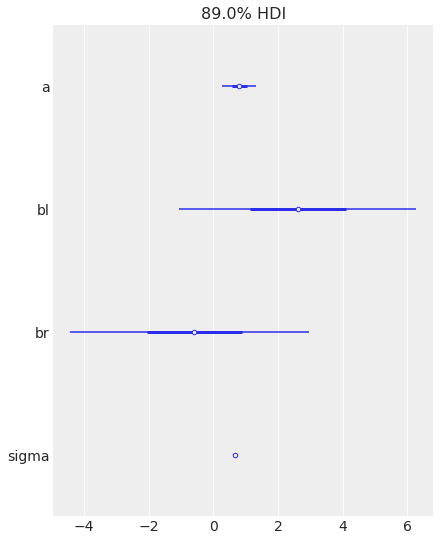

In [5]:
az.plot_forest(post, hdi_prob=0.89)
plt.show()

### Code 6.5

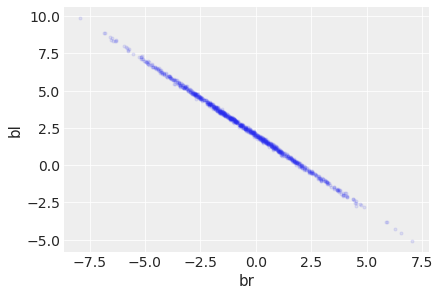

In [6]:
post = m6_1.sample_posterior(random.PRNGKey(1), p6_1, (1000,))
az.plot_pair(post, var_names=["br", "bl"], scatter_kwargs={"alpha": 0.1})
plt.show()

### Code 6.6

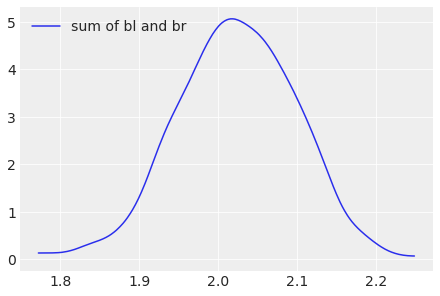

In [7]:
sum_blbr = post["bl"] + post["br"]
az.plot_kde(sum_blbr, label="sum of bl and br")
plt.show()

### Code 6.7

In [8]:
def model(leg_left, height):
    a = numpyro.sample("a", dist.Normal(10, 100))
    bl = numpyro.sample("bl", dist.Normal(2, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bl * leg_left
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m6_2 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m6_2,
    optim.Adam(1),
    Trace_ELBO(),
    leg_left=d.leg_left.values,
    height=d.height.values,
)
p6_2, losses = svi.run(random.PRNGKey(0), 1000)
post = m6_2.sample_posterior(random.PRNGKey(1), p6_2, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:01<00:00, 964.10it/s, init loss: 2486.2397, avg. loss [951-1000]: 110.6718]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.83      0.35      0.84      0.25      1.35    931.50      1.00
        bl      2.02      0.08      2.02      1.91      2.15    940.42      1.00
     sigma      0.67      0.05      0.67      0.60      0.75    949.09      1.00



### Code 6.8

In [9]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["F"] = d["perc.fat"].pipe(lambda x: (x - x.mean()) / x.std())
d["L"] = d["perc.lactose"].pipe(lambda x: (x - x.mean()) / x.std())

### Code 6.9

In [10]:
# kcal.per.g regressed on perc.fat
def model(F, K):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bF = numpyro.sample("bF", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bF * F
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m6_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_3, optim.Adam(1), Trace_ELBO(), F=d.F.values, K=d.K.values)
p6_3, losses = svi.run(random.PRNGKey(0), 1000)

# kcal.per.g regressed on perc.lactose
def model(L, K):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bL = numpyro.sample("bL", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bL * L
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m6_4 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_4, optim.Adam(1), Trace_ELBO(), L=d.L.values, K=d.K.values)
p6_4, losses = svi.run(random.PRNGKey(0), 1000)

post = m6_3.sample_posterior(random.PRNGKey(1), p6_3, (1000,))
print_summary(post, 0.89, False)
post = m6_4.sample_posterior(random.PRNGKey(1), p6_4, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:00<00:00, 1264.72it/s, init loss: 1449.6163, avg. loss [951-1000]: 16.1111]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.01      0.08      0.01     -0.13      0.12    931.50      1.00
        bF      0.86      0.09      0.86      0.73      1.01   1111.41      1.00
     sigma      0.46      0.06      0.46      0.37      0.57    940.36      1.00


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.01      0.07      0.01     -0.11      0.11    931.50      1.00
        bL     -0.90      0.07     -0.90     -1.01     -0.78   1111.90      1.00
     sigma      0.39      0.05      0.39      0.31      0.48    957.31      1.00



### Code 6.10

In [11]:
def model(F, L, K):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bF = numpyro.sample("bF", dist.Normal(0, 0.5))
    bL = numpyro.sample("bL", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bF * F + bL * L
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m6_5 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_5, optim.Adam(1), Trace_ELBO(), F=d.F.values, L=d.L.values, K=d.K.values)
p6_5, losses = svi.run(random.PRNGKey(0), 1000)
post = m6_5.sample_posterior(random.PRNGKey(1), p6_5, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:00<00:00, 1132.23it/s, init loss: 1360.7051, avg. loss [951-1000]: 15.2285]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.00      0.07     -0.00     -0.10      0.10   1049.96      1.00
        bF      0.25      0.19      0.25     -0.05      0.56    822.16      1.00
        bL     -0.67      0.19     -0.67     -0.98     -0.36    872.84      1.00
     sigma      0.39      0.05      0.38      0.31      0.47    959.88      1.00



### Code 6.11

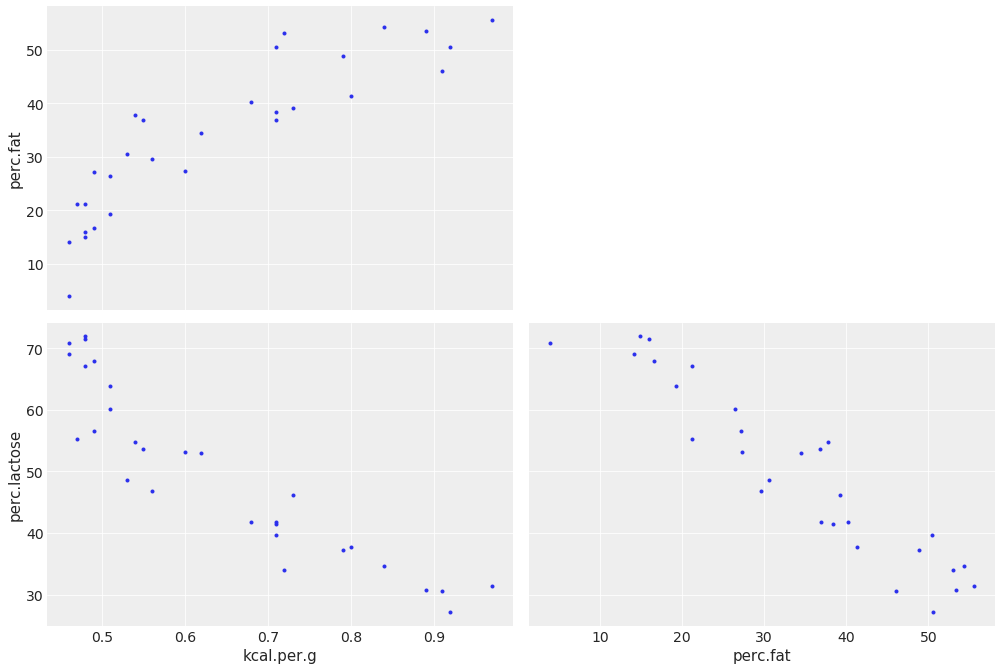

In [12]:
az.plot_pair(d[["kcal.per.g", "perc.fat", "perc.lactose"]].to_dict("list"))
plt.show()

### Code 6.12

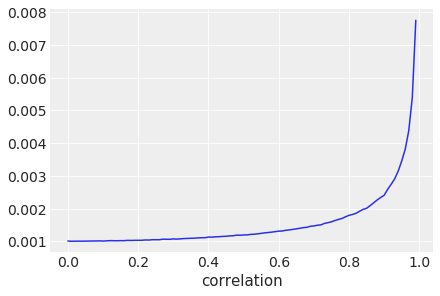

In [13]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk


def sim_coll(i, r=0.9):
    sd = jnp.sqrt((1 - r ** 2) * jnp.var(d["perc.fat"].values))
    x = dist.Normal(r * d["perc.fat"].values, sd).sample(random.PRNGKey(3 * i))

    def model(perc_fat, kcal_per_g):
        intercept = numpyro.sample("intercept", dist.Normal(0, 10))
        b_perc_flat = numpyro.sample("b_perc.fat", dist.Normal(0, 10))
        b_x = numpyro.sample("b_x", dist.Normal(0, 10))
        sigma = numpyro.sample("sigma", dist.HalfCauchy(2))
        mu = intercept + b_perc_flat * perc_fat + b_x * x
        numpyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

    m = AutoLaplaceApproximation(model)
    svi = SVI(
        model,
        m,
        optim.Adam(0.01),
        Trace_ELBO(),
        perc_fat=d["perc.fat"].values,
        kcal_per_g=d["kcal.per.g"].values,
    )
    params, losses = svi.run(random.PRNGKey(3 * i + 1), 20000, progress_bar=False)
    samples = m.sample_posterior(random.PRNGKey(3 * i + 2), params, (1000,))
    vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
    stddev = jnp.sqrt(jnp.diag(vcov))  # stddev of parameter
    return dict(zip(samples.keys(), stddev))["b_perc.fat"]


def rep_sim_coll(r=0.9, n=100):
    stddev = lax.map(lambda i: sim_coll(i, r=r), jnp.arange(n))
    return jnp.nanmean(stddev)


r_seq = jnp.arange(start=0, stop=1, step=0.01)
stddev = lax.map(lambda z: rep_sim_coll(r=z, n=100), r_seq)
plt.plot(r_seq, stddev)
plt.xlabel("correlation")
plt.show()

### Code 6.13

In [14]:
with numpyro.handlers.seed(rng_seed=71):
    # number of plants
    N = 100

    # simulate initial heights
    h0 = numpyro.sample("h0", dist.Normal(10, 2).expand([N]))

    # assign treatments and simulate fungus and growth
    treatment = jnp.repeat(jnp.arange(2), repeats=N // 2)
    fungus = numpyro.sample(
        "fungus", dist.Binomial(total_count=1, probs=(0.5 - treatment * 0.4))
    )
    h1 = h0 + numpyro.sample("diff", dist.Normal(5 - 3 * fungus))

    # compose a clean data frame
    d = pd.DataFrame({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
     fungus      0.31      0.46      0.00      0.00      1.00     18.52      1.17
         h0      9.73      1.95      9.63      7.05     13.33     80.22      0.99
         h1     13.72      2.47     13.60     10.73     18.38     43.44      1.08
  treatment      0.50      0.50      0.50      0.00      1.00      2.64       inf



### Code 6.14

In [15]:
sim_p = dist.LogNormal(0, 0.25).sample(random.PRNGKey(0), (int(1e4),))
print_summary({"sim_p": sim_p}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
     sim_p      1.04      0.27      1.00      0.63      1.44   9936.32      1.00



### Code 6.15

In [16]:
def model(h0, h1):
    p = numpyro.sample("p", dist.LogNormal(0, 0.25))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)


m6_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_6, optim.Adam(1), Trace_ELBO(), h0=d.h0.values, h1=d.h1.values)
p6_6, losses = svi.run(random.PRNGKey(0), 1000)
post = m6_6.sample_posterior(random.PRNGKey(1), p6_6, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:00<00:00, 1072.81it/s, init loss: 279.8950, avg. loss [951-1000]: 204.3793]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      1.39      0.02      1.39      1.36      1.42    994.30      1.00
     sigma      1.84      0.13      1.84      1.65      2.06   1011.70      1.00



### Code 6.16

In [17]:
def model(treatment, fungus, h0, h1):
    a = numpyro.sample("a", dist.LogNormal(0, 0.2))
    bt = numpyro.sample("bt", dist.Normal(0, 0.5))
    bf = numpyro.sample("bf", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    p = a + bt * treatment + bf * fungus
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)


m6_7 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m6_7,
    optim.Adam(0.3),
    Trace_ELBO(),
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
p6_7, losses = svi.run(random.PRNGKey(0), 1000)
post = m6_7.sample_posterior(random.PRNGKey(1), p6_7, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:01<00:00, 814.21it/s, init loss: 151456.4062, avg. loss [951-1000]: 168.2294]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      1.47      0.03      1.47      1.43      1.51   1049.04      1.00
        bf     -0.28      0.03     -0.28     -0.33     -0.23    910.93      1.00
        bt      0.01      0.03      0.01     -0.03      0.06   1123.06      1.00
     sigma      1.39      0.10      1.39      1.21      1.54    976.96      1.00



### Code 6.17

In [18]:
def model(treatment, h0, h1):
    a = numpyro.sample("a", dist.LogNormal(0, 0.2))
    bt = numpyro.sample("bt", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    p = a + bt * treatment
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)


m6_8 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m6_8,
    optim.Adam(1),
    Trace_ELBO(),
    treatment=d.treatment.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
p6_8, losses = svi.run(random.PRNGKey(0), 1000)
post = m6_8.sample_posterior(random.PRNGKey(1), p6_8, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:01<00:00, 940.01it/s, init loss: 87469.1094, avg. loss [951-1000]: 198.4736]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      1.33      0.02      1.33      1.29      1.37    930.82      1.00
        bt      0.13      0.04      0.12      0.08      0.19    880.02      1.00
     sigma      1.73      0.12      1.73      1.55      1.94    948.82      1.00



### Code 6.18

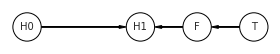

In [19]:
plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"], edges=[("H0", "H1"), ("F", "H1"), ("T", "F")]
)
pgm = daft.PGM()
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}
for node in plant_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in plant_dag.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()

### Code 6.19

In [20]:
all_independencies = plant_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('H0', 'F', set())
('H0', 'T', set())
('H1', 'T', {'F'})


### Code 6.20

In [21]:
with numpyro.handlers.seed(rng_seed=71):
    N = 1000
    h0 = numpyro.sample("h0", dist.Normal(10, 2).expand([N]))
    treatment = jnp.repeat(jnp.arange(2), repeats=N // 2)
    M = numpyro.sample("M", dist.Bernoulli(probs=0.5).expand([N]))
    fungus = numpyro.sample(
        "fungus", dist.Binomial(total_count=1, probs=(0.5 - treatment * 0.4))
    )
    h1 = h0 + numpyro.sample("diff", dist.Normal(5 + 3 * M))
    d2 = pd.DataFrame({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

### Code 6.21

In [22]:
def sim_happiness(seed=1977, N_years=1000, max_age=65, N_births=20, aom=18):
    # age existing individuals & newborns
    A = jnp.repeat(jnp.arange(1, N_years + 1), N_births)
    # sim happiness trait - never changes
    H = jnp.repeat(jnp.linspace(-2, 2, N_births)[None, :], N_years, 0).reshape(-1)
    # not yet married
    M = jnp.zeros(N_years * N_births, dtype=jnp.int32)

    def update_M(i, M):
        # for each person over 17, chance get married
        married = dist.Bernoulli(logits=(H - 4)).sample(random.PRNGKey(seed + i))
        return jnp.where((A >= i) & (M == 0), married, M)

    M = lax.fori_loop(aom, max_age + 1, update_M, M)
    # mortality
    deaths = A > max_age
    A = A[~deaths]
    H = H[~deaths]
    M = M[~deaths]

    d = pd.DataFrame({"age": A, "married": M, "happiness": H})
    return d


d = sim_happiness(seed=1977, N_years=1000)
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
        age     33.00     18.77     33.00      1.00     58.00      2.51      2.64
  happiness      0.00      1.21      0.00     -2.00      1.58    338.78      1.00
    married      0.28      0.45      0.00      0.00      1.00     48.04      1.18



### Code 6.22

In [23]:
d2 = d[d.age > 17].copy()  # only adults
d2["A"] = (d2.age - 18) / (65 - 18)

### Code 6.23

In [24]:
d2["mid"] = d2.married


def model(mid, A, happiness):
    a = numpyro.sample("a", dist.Normal(0, 1).expand([len(set(mid))]))
    bA = numpyro.sample("bA", dist.Normal(0, 2))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[mid] + bA * A
    numpyro.sample("happiness", dist.Normal(mu, sigma), obs=happiness)


m6_9 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m6_9,
    optim.Adam(1),
    Trace_ELBO(),
    mid=d2.mid.values,
    A=d2.A.values,
    happiness=d2.happiness.values,
)
p6_9, losses = svi.run(random.PRNGKey(0), 1000)
post = m6_9.sample_posterior(random.PRNGKey(1), p6_9, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:00<00:00, 1077.70it/s, init loss: 12964.1768, avg. loss [951-1000]: 1383.4532]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.20      0.06     -0.20     -0.30     -0.10   1049.96      1.00
      a[1]      1.23      0.09      1.23      1.09      1.37    898.97      1.00
        bA     -0.69      0.11     -0.69     -0.88     -0.53   1126.51      1.00
     sigma      1.02      0.02      1.02      0.98      1.05    966.00      1.00



### Code 6.24

In [25]:
def model(A, happiness):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bA = numpyro.sample("bA", dist.Normal(0, 2))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bA * A
    numpyro.sample("happiness", dist.Normal(mu, sigma), obs=happiness)


m6_10 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m6_10, optim.Adam(1), Trace_ELBO(), A=d2.A.values, happiness=d2.happiness.values
)
p6_10, losses = svi.run(random.PRNGKey(0), 1000)
post = m6_10.sample_posterior(random.PRNGKey(1), p6_10, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:00<00:00, 1044.79it/s, init loss: 19561.3926, avg. loss [951-1000]: 1551.8595]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.01      0.08      0.01     -0.12      0.12    931.50      1.00
        bA     -0.01      0.13     -0.01     -0.22      0.21    940.88      1.00
     sigma      1.21      0.03      1.21      1.17      1.26    949.78      1.00



### Code 6.25

In [26]:
N = 200  # number of grandparent-parent-child triads
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C
b_PC = 1  # direct effect of P on C
b_U = 2  # direct effect of U on P and C

### Code 6.26

In [27]:
with numpyro.handlers.seed(rng_seed=1):
    U = 2 * numpyro.sample("U", dist.Bernoulli(0.5).expand([N])) - 1
    G = numpyro.sample("G", dist.Normal().expand([N]))
    P = numpyro.sample("P", dist.Normal(b_GP * G + b_U * U))
    C = numpyro.sample("C", dist.Normal(b_PC * P + b_GC * G + b_U * U))
    d = pd.DataFrame({"C": C, "P": P, "G": G, "U": U})

### Code 6.27

In [28]:
def model(P, G, C):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b_PC = numpyro.sample("b_PC", dist.Normal(0, 1))
    b_GC = numpyro.sample("b_GC", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + b_PC * P + b_GC * G
    numpyro.sample("C", dist.Normal(mu, sigma), obs=C)


m6_11 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m6_11, optim.Adam(0.3), Trace_ELBO(), P=d.P.values, G=d.G.values, C=d.C.values
)
p6_11, losses = svi.run(random.PRNGKey(0), 1000)
post = m6_11.sample_posterior(random.PRNGKey(1), p6_11, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:01<00:00, 953.99it/s, init loss: 4805.8164, avg. loss [951-1000]: 355.4688]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.08      0.10     -0.09     -0.24      0.06   1049.96      1.00
      b_GC     -0.71      0.11     -0.71     -0.89     -0.55    813.76      1.00
      b_PC      1.72      0.04      1.72      1.65      1.79    982.64      1.00
     sigma      1.39      0.07      1.39      1.28      1.49    968.54      1.00



### Code 6.28

In [29]:
def model(P, G, U, C):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b_PC = numpyro.sample("b_PC", dist.Normal(0, 1))
    b_GC = numpyro.sample("b_GC", dist.Normal(0, 1))
    b_U = numpyro.sample("U", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + b_PC * P + b_GC * G + b_U * U
    numpyro.sample("C", dist.Normal(mu, sigma), obs=C)


m6_12 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m6_12,
    optim.Adam(1),
    Trace_ELBO(),
    P=d.P.values,
    G=d.G.values,
    U=d.U.values,
    C=d.C.values,
)
p6_12, losses = svi.run(random.PRNGKey(0), 1000)
post = m6_12.sample_posterior(random.PRNGKey(1), p6_12, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:01<00:00, 851.90it/s, init loss: 565.4858, avg. loss [951-1000]: 307.1190]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         U      1.87      0.17      1.88      1.59      2.11   1009.20      1.00
         a     -0.06      0.08     -0.05     -0.18      0.07    766.03      1.00
      b_GC      0.01      0.10      0.01     -0.15      0.17   1031.98      1.00
      b_PC      0.99      0.07      0.99      0.88      1.11   1106.62      1.00
     sigma      1.08      0.05      1.08      0.99      1.16    797.58      1.00



### Code 6.29

In [44]:
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("A", "U"),
        ("A", "C"),
        ("C", "Y"),
        ("U", "B"),
        ("C", "B"),
    ],
)
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)

frozenset({'A'})
frozenset({'C'})


In [36]:
all_adjustment_sets

frozenset({frozenset({'C'}),
           frozenset({'B', 'C'}),
           frozenset({'A', 'B', 'C'}),
           frozenset({'U'}),
           frozenset({'B', 'C', 'U'}),
           frozenset({'A'}),
           frozenset({'A', 'U'}),
           frozenset({'C', 'U'}),
           frozenset({'B', 'U'}),
           frozenset({'A', 'B', 'U'}),
           frozenset({'A', 'C'}),
           frozenset({'A', 'C', 'U'}),
           frozenset({'A', 'B', 'C', 'U'})})

### Code 6.30

In [37]:
dag_6_2 = CausalGraphicalModel(
    nodes=["S", "A", "D", "M", "W"],
    edges=[
        ("S", "A"),
        ("A", "D"),
        ("S", "M"),
        ("M", "D"),
        ("S", "W"),
        ("W", "D"),
        ("A", "M"),
    ],
)
all_adjustment_sets = dag_6_2.get_all_backdoor_adjustment_sets("W", "D")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        print(s)

frozenset({'M', 'A'})
frozenset({'S'})


### Code 6.31

In [38]:
all_independencies = dag_6_2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('W', 'A', {'S'})
('W', 'M', {'S'})
('D', 'S', {'W', 'M', 'A'})


In [39]:
all_independencies

[('W', 'A', {'S'}),
 ('W', 'A', {'M', 'S'}),
 ('W', 'M', {'S'}),
 ('W', 'M', {'A', 'S'}),
 ('D', 'S', {'A', 'M', 'W'})]

In [45]:
dag_6M1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A", "V"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("A", "U"),
        ("A", "C"),
        ("C", "Y"),
        ("U", "B"),
        ("C", "B"),
        ("V", "C"),
        ("V", "Y"),
    ],
)
all_adjustment_sets = dag_6M1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if "U" not in s and "V" not in s:
            print(s)

frozenset({'A'})


In [69]:
dag_6M3a = CausalGraphicalModel(
    nodes=["X", "Y", "Z", "A"],
    edges=[
        ("X", "Y"),
        ("Z", "X"),
        ("Z", "Y"),
        ("A", "Z"),
        ("A", "Y"),
    ],
)


In [70]:
dag_6M3a.get_all_backdoor_adjustment_sets("X", "Y")

frozenset({frozenset({'Z'}), frozenset({'A', 'Z'})})

In [71]:
dag_6M3a.get_all_independence_relationships()

[('X', 'A', {'Z'})]

In [72]:
dag_6M3b = CausalGraphicalModel(
    nodes=["X", "Y", "Z", "A"],
    edges=[
        ("X", "Y"),
        ("X", "Z"),
        ("Z", "Y"),
        ("A", "Z"),
        ("A", "Y"),
    ],
)


In [73]:
dag_6M3b.get_all_independence_relationships()

[('X', 'A', set())]

In [74]:
dag_6M3b.get_all_backdoor_adjustment_sets("X", "Y")

frozenset({frozenset(), frozenset({'A'})})

In [52]:
dag_6M3c = CausalGraphicalModel(
    nodes=["X", "Y", "Z", "A"],
    edges=[
        ("X", "Y"),
        ("X", "Z"),
        ("Y", "Z"),
        ("A", "Z"),
        ("A", "X"),
    ],
)
dag_6M3c.get_all_backdoor_adjustment_sets("X", "Y")

frozenset({frozenset(), frozenset({'A'})})

[('Y', 'A', {'X'})]

In [61]:
dag_6H2 = CausalGraphicalModel(
    nodes=["area", "avgfood", "groupsize", "weight"],
    edges=[
        ("area", "avgfood"),
        ("avgfood", "groupsize"),
        ("avgfood", "weight"),
        ("groupsize", "weight"),
    ],
)


In [68]:
dag_6H2.get_all_backdoor_adjustment_sets("groupsize", "weight")

frozenset({frozenset({'avgfood'}), frozenset({'area', 'avgfood'})})

In [67]:
dag_6H2.get_all_independence_relationships()

[('groupsize', 'area', {'avgfood'}),
 ('groupsize', 'area', {'avgfood', 'weight'}),
 ('area', 'weight', {'avgfood'}),
 ('area', 'weight', {'avgfood', 'groupsize'})]

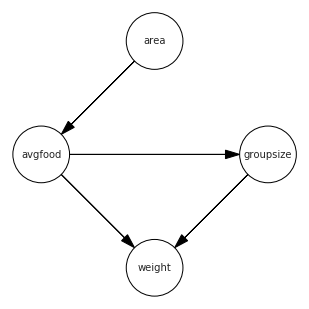

In [90]:
fox_dag = CausalGraphicalModel(
    nodes=["area", "avgfood", "groupsize", "weight"],
    edges=[
        ("area", "avgfood"),
        ("avgfood", "groupsize"),
        ("avgfood", "weight"),
        ("groupsize", "weight"),
    ]
)
pgm = daft.PGM()
coordinates = {
    "area": (0, 2),
    "avgfood": (-2, 0),
    "groupsize": (2, 0),
    "weight": (0, -2)}
for node in fox_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node], scale=2)
for edge in fox_dag.dag.edges:
    pgm.add_edge(*edge, plot_params={"head_width": 0.3, "head_length": 0.5})
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()

In [91]:
foxes = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/foxes.csv", sep=";")
d = foxes
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 5 columns):
group        116 non-null int64
avgfood      116 non-null float64
groupsize    116 non-null int64
area         116 non-null float64
weight       116 non-null float64
dtypes: float64(3), int64(2)
memory usage: 4.7 KB


,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [92]:
d["F"] = d["avgfood"].pipe(lambda x: (x - x.mean()) / x.std())
d["G"] = d["groupsize"].pipe(lambda x: (x - x.mean()) / x.std())
d["A"] = d["area"].pipe(lambda x: (x - x.mean()) / x.std())
d["W"] = d["weight"].pipe(lambda x: (x - x.mean()) / x.std())

In [114]:
def model(A, n_groups=None, group=None, W=None):
    a_loc = numpyro.sample("a_loc", dist.Normal(0, 0.2))
    a_scale = numpyro.sample("a_scale", dist.HalfNormal(1))
    bA_loc = numpyro.sample("bA_loc", dist.Normal(0, 0.4))
    bA_scale = numpyro.sample("bA_scale", dist.HalfNormal(1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    if group is not None:
        with numpyro.plate("group", n_groups):
            config = {
                "a": TransformReparam(),
                "bA": TransformReparam(),
                     }
            with numpyro.handlers.reparam(config=config):
                a = numpyro.sample(
                    "a",
                    dist.TransformedDistribution(
                        dist.Normal(
                        loc=jnp.zeros(1),
                        scale=0.1
                        ),
                        dist.transforms.AffineTransform(a_loc, a_scale)
                    )
                )
                bA = numpyro.sample(
                    "bA",
                    dist.TransformedDistribution(
                        dist.Normal(
                        loc=jnp.zeros(1),
                        scale=0.1
                        ),
                        dist.transforms.AffineTransform(bA_loc, bA_scale)
                    )
                ).squeeze()

        mu = numpyro.deterministic("mu", a[group] + bA[group] * A)
    else:
        mu = numpyro.deterministic("mu", a_loc + bA_loc * A)
        
    numpyro.sample("W", dist.Normal(mu, sigma), obs=W)


m_6H3 = NUTS(model)
mcmc = MCMC(m_6H3, num_samples=2000, num_warmup=2000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,
         group=d["group"].values - 1,
         n_groups=d["group"].nunique(),
         A=d["A"].values,
         W=d["W"].values,)

post_6H3 = az.from_numpyro(posterior=mcmc)
print_summary(mcmc.get_samples(), 0.89, False)


sample: 100%|██████████| 4000/4000 [00:07<00:00, 512.65it/s, 15 steps of size 3.18e-01. acc. prob=0.89]



                 mean       std    median      5.5%     94.5%     n_eff     r_hat
       a[0]     -0.00      0.14     -0.00     -0.21      0.21   2759.88      1.00
       a[1]      0.03      0.14      0.02     -0.19      0.24   2685.60      1.00
       a[2]      0.00      0.14      0.00     -0.22      0.19   2304.68      1.00
       a[3]      0.00      0.13      0.00     -0.21      0.20   2969.69      1.00
       a[4]      0.04      0.14      0.03     -0.20      0.24   2134.66      1.00
       a[5]      0.02      0.13      0.01     -0.18      0.22   2504.67      1.00
       a[6]      0.03      0.14      0.02     -0.18      0.24   2497.07      1.00
       a[7]      0.01      0.14      0.01     -0.21      0.21   2754.53      1.00
       a[8]      0.04      0.14      0.03     -0.17      0.25   2582.82      1.00
       a[9]      0.02      0.13      0.01     -0.18      0.22   2559.54      1.00
      a[10]      0.01      0.13      0.01     -0.18      0.24   2782.23      1.00
      a[11]    

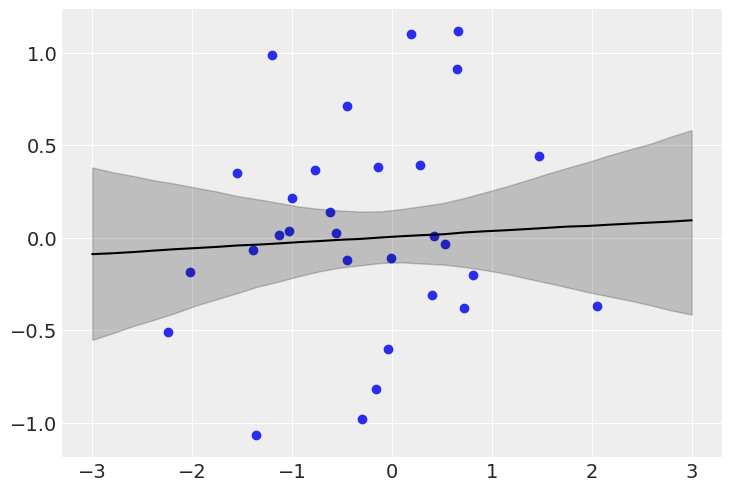

In [103]:
A_seq = jnp.linspace(-3, 3, num=30)
post_pred = Predictive(m_6H3.model, post_6H3)(random.PRNGKey(2), A=A_seq)

mu_PI = jnp.percentile(post_pred["mu"], [50, 5.5, 94.5], axis=0)

plt.scatter(d.groupby("group").mean()["A"], d.groupby("group").mean()["W"].values)
plt.plot(A_seq, mu_PI[0], "k-")
plt.fill_between(A_seq, mu_PI[1], mu_PI[2], color="k", alpha=0.2)
plt.show()

In [134]:
def model(F, n_groups=None, group=None, W=None):
    a_loc = numpyro.sample("a_loc", dist.Normal(0, 0.2))
    a_scale = numpyro.sample("a_scale", dist.HalfNormal(1))
    bF_loc = numpyro.sample("bF_loc", dist.Normal(0, 0.4))
    bF_scale = numpyro.sample("bF_scale", dist.HalfNormal(1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    if group is not None:
        with numpyro.plate("group", n_groups):
            config = {
                "a": TransformReparam(),
                "bF": TransformReparam(),
                     }
            with numpyro.handlers.reparam(config=config):
                a = numpyro.sample(
                    "a",
                    dist.TransformedDistribution(
                        dist.Normal(
                        loc=jnp.zeros(1),
                        scale=0.1
                        ),
                        dist.transforms.AffineTransform(a_loc, a_scale)
                    )
                )
                bF = numpyro.sample(
                    "bF",
                    dist.TransformedDistribution(
                        dist.Normal(
                        loc=jnp.zeros(1),
                        scale=0.1
                        ),
                        dist.transforms.AffineTransform(bF_loc, bF_scale)
                    )
                ).squeeze()

        mu = numpyro.deterministic("mu", a[group] + bF[group] * F)
    else:
        mu = numpyro.deterministic("mu", a_loc + bF_loc * F)
        
    numpyro.sample("W", dist.Normal(mu, sigma), obs=W)


m_6H4 = NUTS(model)
mcmc = MCMC(m_6H4, num_samples=2000, num_warmup=2000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,
         group=d["group"].values - 1,
         n_groups=d["group"].nunique(),
         F=d["F"].values,
         W=d["W"].values,)

#post_6H4 = mcmc.get_samples()
post_6H4 = az.from_numpyro(posterior=mcmc)
print_summary(mcmc.get_samples(), 0.89, False)

sample: 100%|██████████| 4000/4000 [00:08<00:00, 481.06it/s, 15 steps of size 3.32e-01. acc. prob=0.87]



                 mean       std    median      5.5%     94.5%     n_eff     r_hat
       a[0]     -0.00      0.14     -0.00     -0.20      0.20   2967.67      1.00
       a[1]      0.03      0.14      0.02     -0.18      0.24   3308.55      1.00
       a[2]      0.00      0.13      0.00     -0.21      0.19   2918.63      1.00
       a[3]      0.00      0.13      0.01     -0.20      0.21   2495.86      1.00
       a[4]      0.04      0.14      0.03     -0.18      0.24   1856.16      1.00
       a[5]      0.01      0.13      0.01     -0.19      0.21   2951.59      1.00
       a[6]      0.03      0.14      0.02     -0.17      0.25   2552.44      1.00
       a[7]      0.01      0.13      0.01     -0.20      0.22   3154.69      1.00
       a[8]      0.04      0.14      0.03     -0.16      0.26   2559.90      1.00
       a[9]      0.02      0.13      0.01     -0.20      0.20   2988.34      1.00
      a[10]      0.01      0.13      0.01     -0.18      0.22   2692.52      1.00
      a[11]    

In [ ]:
az.plot_trace(post_6H4, var_names=("a_loc", "a_scale", "bF_loc", "bF_scale", "a", "bF", "sigma"))


In [135]:
def inv_softplus(x):
    return x + jnp.log(-jnp.expm1(-x))  # == log(expm1(x))

def model(F, n_groups=None, group=None, W=None):
    a_loc = numpyro.sample("a_loc", dist.Normal(0, 0.5))
    bF_loc = numpyro.sample("bF_loc", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    
    config = {
        "a_scale": TransformReparam(),
        "bF_scale": TransformReparam(),
             }
    with numpyro.handlers.reparam(config=config):
        a_scale = numpyro.sample(
            "a_scale",
            dist.TransformedDistribution(
                dist.Normal(
                loc=inv_softplus(1),
                scale=1
                ),
                dist.transforms.SoftplusTransform()
            )
        )

        bF_scale = numpyro.sample(
            "bF_scale",
            dist.TransformedDistribution(
                dist.Normal(
                loc=inv_softplus(1),
                scale=1
                ),
                dist.transforms.SoftplusTransform()
            )
        )

    if group is not None:
        with numpyro.plate("group", n_groups):
            config = {
                "a": TransformReparam(),
                "bF": TransformReparam(),
                     }
            with numpyro.handlers.reparam(config=config):
                a = numpyro.sample(
                    "a",
                    dist.TransformedDistribution(
                        dist.Normal(
                        loc=jnp.zeros(1),
                        scale=0.1
                        ),
                        dist.transforms.AffineTransform(a_loc, a_scale)
                    )
                )
                bF = numpyro.sample(
                    "bF",
                    dist.TransformedDistribution(
                        dist.Normal(
                        loc=jnp.zeros(1),
                        scale=0.1
                        ),
                        dist.transforms.AffineTransform(bF_loc, bF_scale)
                    )
                ).squeeze()

        mu = numpyro.deterministic("mu", a[group] + bF[group] * F)
    else:
        mu = numpyro.deterministic("mu", a_loc + bF_loc * F)
        
    numpyro.sample("W", dist.Normal(mu, sigma), obs=W)


m_6H4 = NUTS(model)
mcmc = MCMC(m_6H4, num_samples=2000, num_warmup=2000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,
         group=d["group"].values - 1,
         n_groups=d["group"].nunique(),
         F=d["F"].values,
         W=d["W"].values,)

#post_6H4 = mcmc.get_samples()
post_6H4 = az.from_numpyro(posterior=mcmc)
print_summary(mcmc.get_samples(), 0.89, False)

sample: 100%|██████████| 4000/4000 [00:08<00:00, 863.03it/s, 7 steps of size 4.69e-01. acc. prob=0.86] 



                     mean       std    median      5.5%     94.5%     n_eff     r_hat
           a[0]      0.00      0.17      0.01     -0.26      0.23   2284.39      1.00
           a[1]      0.05      0.17      0.04     -0.20      0.32   1784.94      1.00
           a[2]      0.02      0.17      0.01     -0.25      0.27   2140.85      1.00
           a[3]      0.01      0.16      0.01     -0.22      0.27   2099.85      1.00
           a[4]      0.08      0.17      0.06     -0.17      0.34   1754.54      1.00
           a[5]      0.02      0.16      0.02     -0.21      0.27   2140.41      1.00
           a[6]      0.05      0.16      0.04     -0.21      0.30   2245.12      1.00
           a[7]      0.01      0.16      0.01     -0.24      0.26   1661.61      1.00
           a[8]      0.06      0.17      0.05     -0.20      0.30   2027.92      1.00
           a[9]      0.04      0.16      0.04     -0.21      0.30   2288.69      1.00
          a[10]      0.02      0.15      0.02     -0.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x167d9d990>,
      dtype=object)

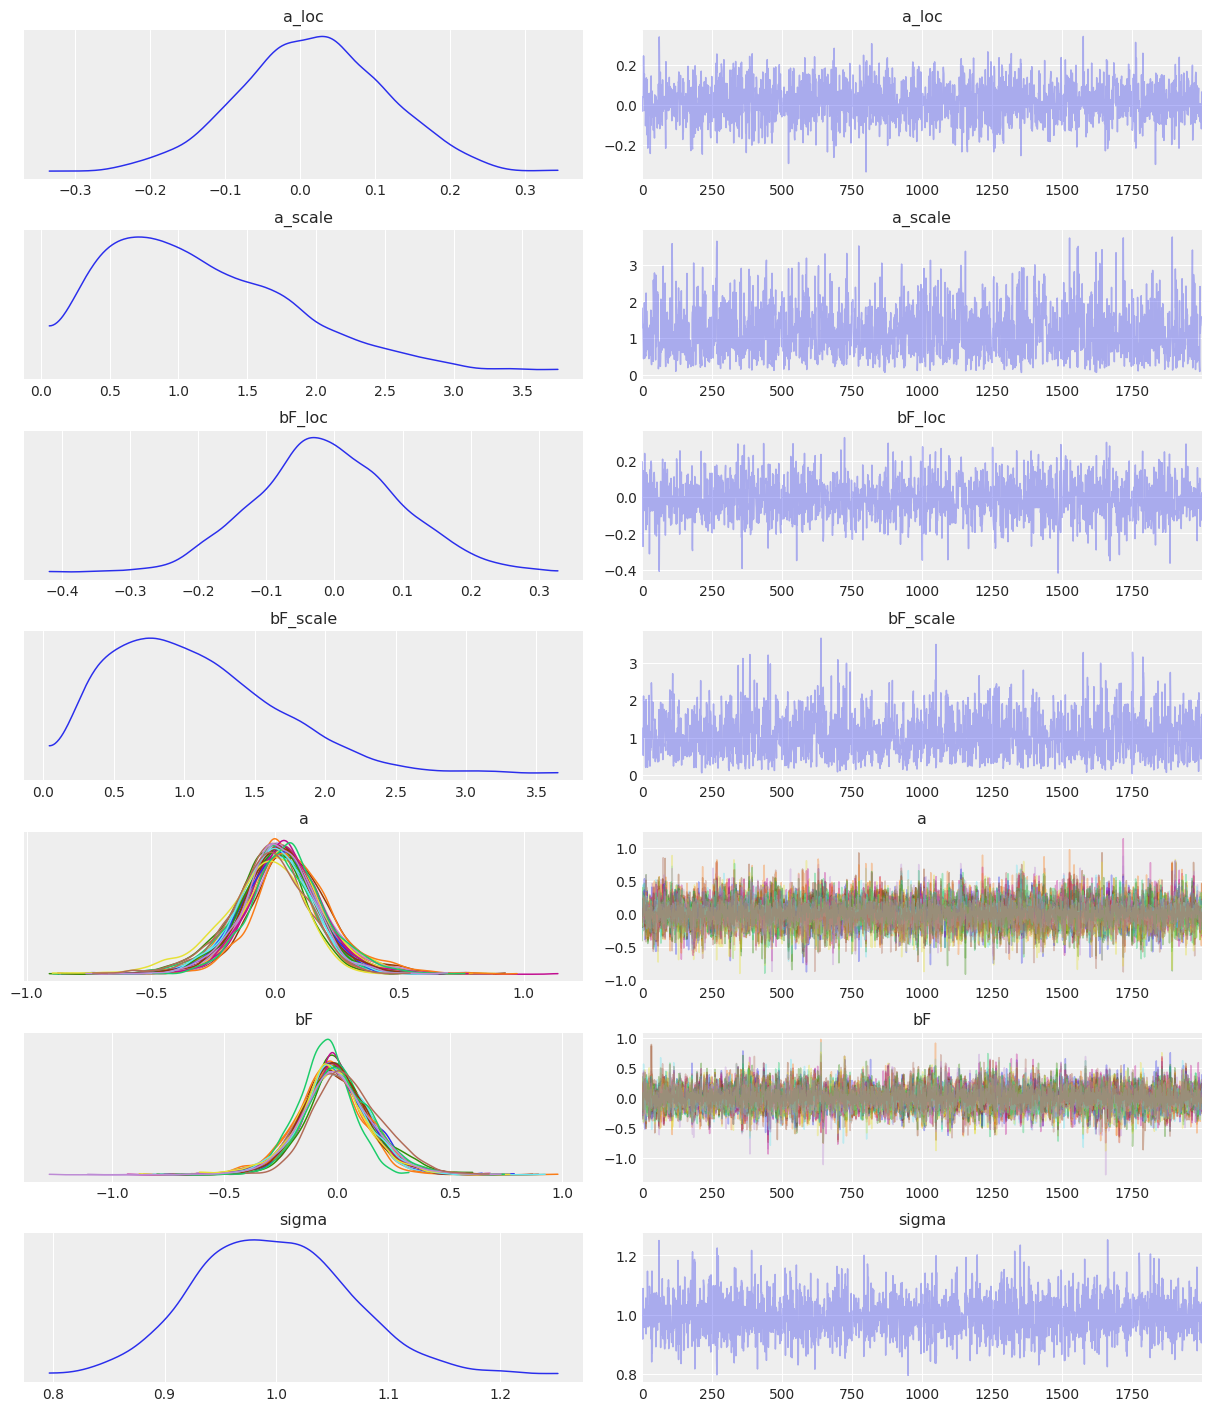

In [136]:
az.plot_trace(post_6H4, var_names=("a_loc", "a_scale", "bF_loc", "bF_scale", "a", "bF", "sigma"))


In [184]:
def inv_softplus(x):
    return x + jnp.log(-jnp.expm1(-x))  # == log(expm1(x))

def G_model(F, n_groups=None, group=None, G=None):
    a = numpyro.sample("Ga", dist.Normal(0, 0.5))
    bF = numpyro.sample("GbF", dist.Normal(0, 0.5))
    sigma = numpyro.sample("G_sigma", dist.HalfNormal(1))
    mu = numpyro.deterministic("G_mu", a + bF * F)
    G = numpyro.sample("G", dist.Normal(loc=mu, scale=sigma), obs=G)

    return G

def W_model(F, n_groups=None, group=None, G=None, W=None):
    a = numpyro.sample("Wa", dist.Normal(0, 0.2))
    bG = numpyro.sample("WbG", dist.Normal(0, 0.5))
    bF = numpyro.sample("WbF", dist.Normal(0, 0.5))
    sigma = numpyro.sample("W_sigma", dist.HalfNormal(1))
    mu = numpyro.deterministic("W_mu", a + bG * G + bF * F)
    
    numpyro.sample("W", dist.Normal(mu, sigma), obs=W)

def model(F, n_groups=None, group=None, G=None, W=None):
    W_model(F, n_groups, group, G_model(F, n_groups, group, G), W)

m_6H5 = NUTS(model)
mcmc = MCMC(m_6H5, num_samples=2000, num_warmup=5000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,
         group=d["group"].values - 1,
         n_groups=d["group"].nunique(),
         F=d["F"].values,
         W=d["W"].values,
         G=d["G"].values)

#post_6H4 = mcmc.get_samples()
post_6H5 = az.from_numpyro(posterior=mcmc)
print_summary(mcmc.get_samples(), 0.89, False)

sample: 100%|██████████| 7000/7000 [00:12<00:00, 579.61it/s, 15 steps of size 3.65e-01. acc. prob=0.92]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
   G_mu[0]     -1.72      0.09     -1.72     -1.86     -1.58   2000.02      1.00
   G_mu[1]     -1.72      0.09     -1.72     -1.86     -1.58   2000.02      1.00
   G_mu[2]     -1.00      0.06     -1.00     -1.09     -0.90   1938.23      1.00
   G_mu[3]     -1.00      0.06     -1.00     -1.09     -0.90   1938.23      1.00
   G_mu[4]     -1.18      0.07     -1.18     -1.28     -1.07   1951.30      1.00
   G_mu[5]     -1.18      0.07     -1.18     -1.28     -1.07   1951.30      1.00
   G_mu[6]     -1.36      0.08     -1.36     -1.48     -1.24   1967.14      1.00
   G_mu[7]     -1.36      0.08     -1.36     -1.48     -1.24   1967.14      1.00
   G_mu[8]     -0.05      0.04     -0.05     -0.11      0.02   1930.73      1.00
   G_mu[9]     -0.05      0.04     -0.05     -0.11      0.02   1930.73      1.00
  G_mu[10]     -0.05      0.04     -0.05     -0.11      0.02   1930.73      1.00
  G_mu[11]     -0.82      0

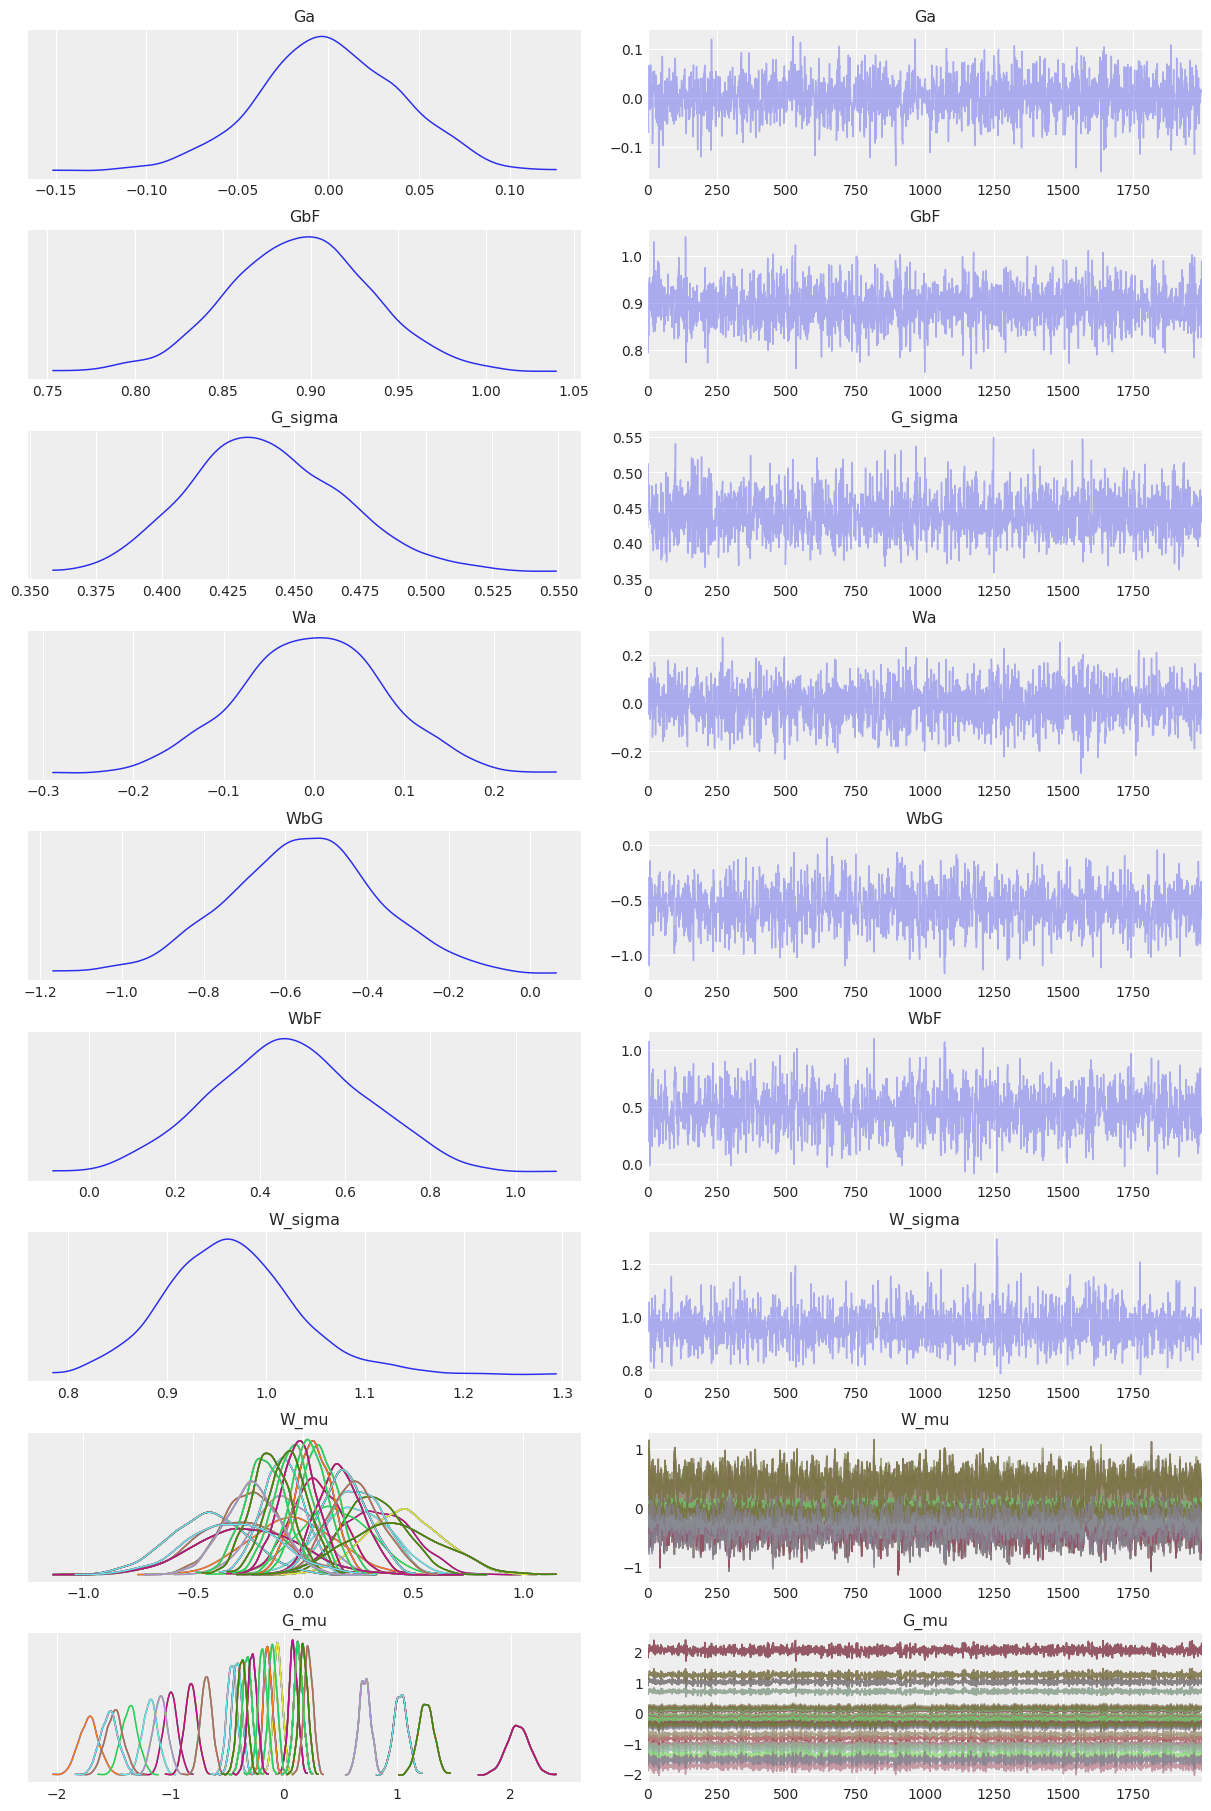

In [185]:
az.plot_trace(post_6H5, var_names=["Ga", "GbF", "G_sigma", "Wa", "WbG", "WbF", "W_sigma", "W_mu", "G_mu"])
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x19d8a94d0>],
      dtype=object)

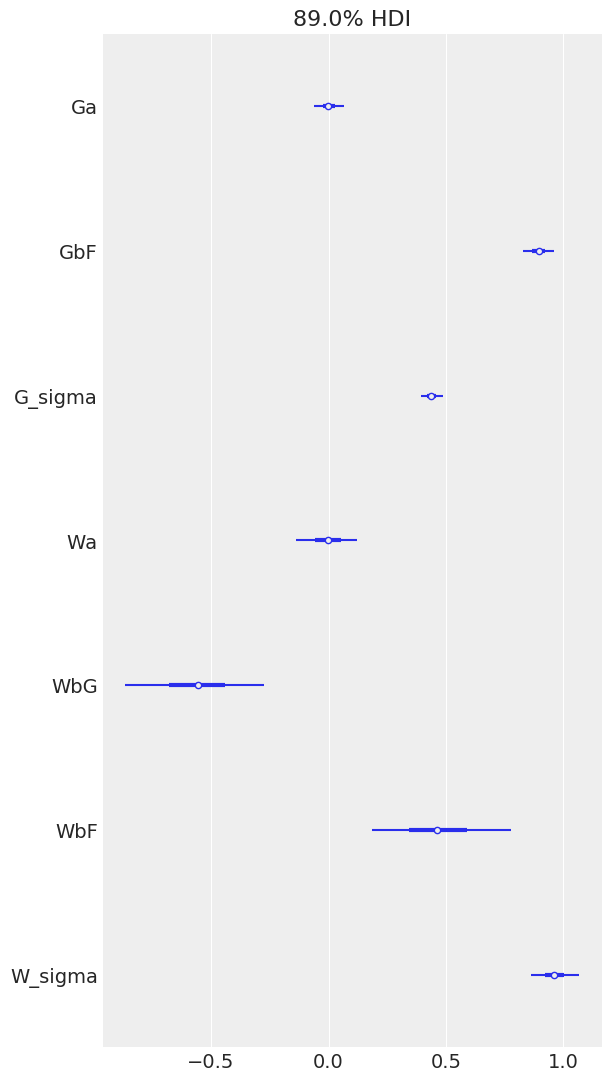

In [188]:
az.plot_forest(post_6H5, var_names=["Ga", "GbF", "G_sigma", "Wa", "WbG", "WbF", "W_sigma"], hdi_prob=0.89)